In [99]:
import h5py
import time
import numpy as np
from gurobipy import *
import operator
import functools
# Read the product costs and prices dictionary calcuated earlier after the simluations. This dictionary is strctured as follows
#dic={product ID: [product cost, product price]} where prod ID =[0,25699], and each product has a array with the cost and price
#being the first and second element
def sumproduct(*lists):
    return sum(functools.reduce(operator.mul, data) for data in zip(*lists))
product_pricet={}
s = open('product-price.txt', 'r').read()
product_pricet = eval(s)
cost=[]
price=[]
MAX_TEST= 25700
num_scen =50
for k,v in product_pricet.items():
    if k<MAX_TEST:
        cost.append(product_pricet[k][0])
        price.append(product_pricet[k][1])
C_u=[p-c for p,c in zip(price,cost)]# coefficient of underage costs for each product ( C_u = price - cost)
C_o= cost # coeficient of overage costs for each product.We assume zero salvage and the whole excesss inventory is written off
#print(len(C_u))
start= time.time()   

X = {}
a = {}
b = {}

with h5py.File('store-scen.hdf5', 'r+') as f:
    dtest = f['Scenarios'][0:num_scen,0:MAX_TEST]
    #Defining the model and decision variables
    m = Model()
    
    for i in range (MAX_TEST):
        X[i] = m.addVar (vtype = GRB.INTEGER, lb = 0)
        
    
    for k in range(num_scen):
        for kk in range(MAX_TEST):
            a[k,kk] = m.addVar(vtype = GRB.CONTINUOUS, lb =0)
            b[k,kk] = m.addVar(vtype = GRB.CONTINUOUS, lb =0)
            
    m.update()
    for k in range(num_scen):
        for kk in range(MAX_TEST):
            m.addConstr(a[k,kk] >= X[kk]-dtest[k,kk])
            m.addConstr(b[k,kk] >= dtest[k,kk] - X[kk])
        
        print(k)
    objective = (1/num_scen)*quicksum(a[k,kk]*C_o[kk] + b[k,kk]*C_u[kk] for (k,kk) in a)
    m.setObjective(objective)
    m.update()
    e1 = time.time()
    print("added objective and constraints", e1-start)
    m.optimize()
    
    objval = m.objval
    
    OptSol ={}
    #prob = cp.Problem(cp.Minimize(obj/num_scen),con)
    #prob.solve()
    e2 = time.time()
    print("SOLVED", e2-e1)
    OptSol[0]= objval
    for k in range(1,len(X)+1):
        OptSol[k]=(X[k-1])
    with open('optimalproducts.txt', 'w') as write:
        print(OptSol, file=write)
f.close()

end = time.time()
print("TOTAL RUN TIME", end- start)
print(objval)



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
added objective and constraints 105.8877272605896
Optimize a model with 2570000 rows, 2595700 columns and 5140000 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [9e-07, 2e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+08]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 137684 rows and 138397 columns
Presolve time: 5.25s
Presolved: 2432316 rows, 2457303 columns, 4864632 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.180e+08
 Factor NZ  : 1.204e+08 (roughly 3.0 GBytes of memory)
 Factor Ops : 7.946e+09 (roughly 1 second per iteration)
 Threads    : 3

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.01186622e+15  2.65486860e+08  1.10e+07

In [100]:
# Calculation of Upper and lower bounds to get relative optimal gap. We use sample sizes shown below to calculate the
#LB which is the solution of the optimization problem solved above. We plug the slution of LB into a set of scenarios to 
#calculate the UB. We repeat this 'opt' number of times for each sampe size to get an interval for the error on both LB and 
# consequently the UB. Running 50  optimizations given [10,25,50,75, 100] samples takes~ 5 hours..
import h5py
import time
import numpy as np
from gurobipy import *
import operator
import functools
# Read the product costs and prices dictionary calcuated earlier after the simluations. This dictionary is strctured as follows
#dic={product ID: [product cost, product price]} where prod ID =[0,25699], and each product has a array with the cost and price
#being the first and second element
def sumproduct(*lists):
    return sum(functools.reduce(operator.mul, data) for data in zip(*lists))
samplesize = [10,25, 50, 75, 100]
opt = 10 # note that for 100 opt can only be a max of 10 as we ony have 100*10 + 100*10 = 2000 scenarios generated.
LB = np.zeros((len(samplesize),opt))
UB = np.zeros((len(samplesize),opt))
relgap = np.zeros(len(samplesize))
s = open('product-price.txt', 'r').read()
product_pricet = eval(s)
cost=[]
price=[]
MAX_TEST= 25700 # number of products to be considered in the problem We are doing the whoe set of 25700 products for these instances

for k,v in product_pricet.items():
    if k<MAX_TEST:
        cost.append(product_pricet[k][0])
        price.append(product_pricet[k][1])
C_u=[p-c for p,c in zip(price,cost)]# coefficient of underage costs for each product ( C_u = price - cost)
C_o= cost # coeficient of overage costs for each product.We assume zero salvage and the whole excesss inventory is written off
#print(len(C_u))
start= time.time()   
for sample in range(len(samplesize)):
    num_scen =samplesize[sample]
    X = {}
    a = {}
    b = {}
    #Defining the model and decision variables
    m = Model()
    for i in range (MAX_TEST):
        X[i] = m.addVar (vtype = GRB.CONTINUOUS, lb = 0)
     
    
    for k in range(num_scen):
        for kk in range(MAX_TEST):
            a[k,kk] = m.addVar(vtype = GRB.CONTINUOUS, lb =0)
            b[k,kk] = m.addVar(vtype = GRB.CONTINUOUS, lb =0)
    
    objective = (1/num_scen)*quicksum(a[k,kk]*C_o[kk] + b[k,kk]*C_u[kk] for (k,kk) in a)
    m.setObjective(objective)
    m.setParam( 'OutputFlag', False )
    m.update()
    
    for O in range(opt):
        Sol=[]
        with h5py.File('store-scen.hdf5', 'r+') as f:
            dtest = f['Scenarios'][O*num_scen:(O+1)*num_scen,:MAX_TEST]   
            for k in range(num_scen):
                for kk in range(MAX_TEST):
                    m.addConstr(a[k,kk] >= X[kk]-dtest[k,kk])
                    m.addConstr(b[k,kk] >= dtest[k,kk] - X[kk])
        
                #print(k)
            m.update()
            m.optimize()
            LB[sample][O]= m.objval
            
        print("LB-", sample, O)    
        f.close()
        # CALC UB
        with h5py.File('store-scen.hdf5', 'r+') as f:
            dtest = f['Scenarios'][1000+O*num_scen:(O+1)*num_scen+1000,:MAX_TEST]
            UBVAL=0
            for v in range(num_scen):
                for u in range(MAX_TEST):
                    UBVAL+= np.maximum(0, X[u].x- dtest[v,u])*C_o[u] + np.maximum(0,-X[u].x +dtest[v,u])*C_u[u]
            UB[sample][O]= UBVAL/num_scen
        f.close()
        m.remove(m.getConstrs())
        m.update()
        print("UB-", sample, O) 
# writing the UB and LB vals in a file to calcukate confidence intervals and relative optimality gaps
np.savetxt('UB.out', UB, delimiter=' ')
np.savetxt('LB.out', LB, delimiter=' ')

    

LB- 0 0
UB- 0 0
LB- 0 1
UB- 0 1
LB- 0 2
UB- 0 2
LB- 0 3
UB- 0 3
LB- 0 4
UB- 0 4
LB- 0 5
UB- 0 5
LB- 0 6
UB- 0 6
LB- 0 7
UB- 0 7
LB- 0 8
UB- 0 8
LB- 0 9
UB- 0 9
LB- 1 0
UB- 1 0
LB- 1 1
UB- 1 1
LB- 1 2
UB- 1 2
LB- 1 3
UB- 1 3
LB- 1 4
UB- 1 4
LB- 1 5
UB- 1 5
LB- 1 6
UB- 1 6
LB- 1 7
UB- 1 7
LB- 1 8
UB- 1 8
LB- 1 9
UB- 1 9
LB- 2 0
UB- 2 0
LB- 2 1
UB- 2 1
LB- 2 2
UB- 2 2
LB- 2 3
UB- 2 3
LB- 2 4
UB- 2 4
LB- 2 5
UB- 2 5
LB- 2 6
UB- 2 6
LB- 2 7
UB- 2 7
LB- 2 8
UB- 2 8
LB- 2 9
UB- 2 9
LB- 3 0
UB- 3 0
LB- 3 1
UB- 3 1
LB- 3 2
UB- 3 2
LB- 3 3
UB- 3 3
LB- 3 4
UB- 3 4
LB- 3 5
UB- 3 5
LB- 3 6
UB- 3 6
LB- 3 7
UB- 3 7
LB- 3 8
UB- 3 8
LB- 3 9
UB- 3 9
LB- 4 0
UB- 4 0
LB- 4 1
UB- 4 1
LB- 4 2
UB- 4 2
LB- 4 3
UB- 4 3
LB- 4 4
UB- 4 4
LB- 4 5
UB- 4 5
LB- 4 6
UB- 4 6
LB- 4 7
UB- 4 7
LB- 4 8
UB- 4 8
LB- 4 9
UB- 4 9


[0.21767695 0.08330705 0.04180179 0.02788581 0.02077828]


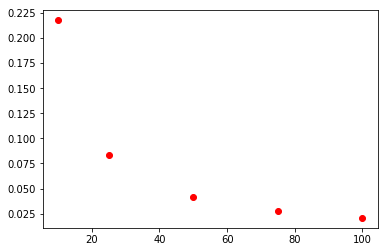

In [115]:
import matplotlib.pyplot as plt

UB= np.loadtxt('UB.out')
LB= np.loadtxt('LB.out')
L = np.zeros((len(LB),3))
U = np.zeros((len(UB),3))

#Calc mean 
for i in range(len(LB)):
    L[i][0] = np.mean(LB[i])
    L[i][1] = np.std(LB[i])
    L[i][2]= 2.262*L[i][1]/np.sqrt(10)
for i in range(len(UB)):
    U[i][0] = np.mean(UB[i])
    U[i][1] = np.std(UB[i])
    U[i][2]= 2.262*U[i][1]/np.sqrt(10)


# L[i][3]- For a confidence interval of 95% and given we did OPt = 10 optimizations per sample size t_{alpha/2}(N-1) = 2.262
#Relative Gap % =(U−L+ εU + εL)/(L−εL) ·100%.  We can calculate this for all the  sample sizes we calculated
samplesize = [10,25, 50, 75, 100]
relgap= np.zeros(len(samplesize))
for i in range(len(samplesize)):
    relgap[i] = (U[i][0]-L[i][0] + U[i][2]+L[i][2])/(L[i][0]-L[i][2])
    
print(relgap)   
plt.plot(samplesize, relgap, 'ro')

plt.show()